# AceleraDev Data Science Project - Recommender System to Generate Leads based on Clients' Portfolio
___

## 1.0 Introduction

### 1.1 Objective

This product's objective is to provide an automated service that recommends new business leads to a user given his current clients portfolio.

### 1.1 Technical Requirements

* Use data science and machine learning techniques to develop the project;
* Present the development and outputs in a Jupyter Notebook or another similar technology;
* The analysis must consider the steps: 
    * exploratory data analysis; 
    * data cleaning;
    * algorithm assessment/selection;
    * model training;
    * model performance assessment;
    * results visualization.
* The time taken to train and give outputs must be less than 20 minutes.

### 1.2 Defining the Process

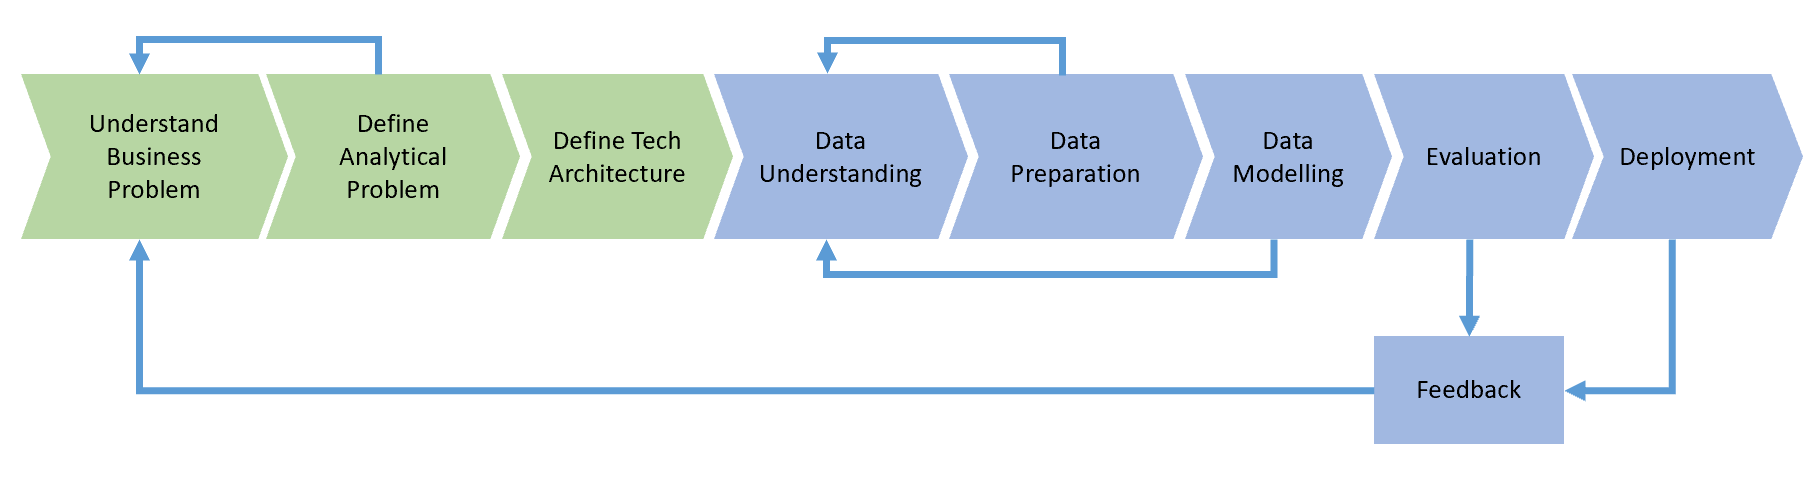
[ref](http://drunkendatascience.com/the-data-science-process-post-2-defining-the-project/)

* **Business problem**: Which companies from the populace have the highest probability of becoming new clients given the current client portfolio. The solution must be applicable/useful to any user with a client portfolio.
* **Analytical problem**: the problem seems to be potentially solvable by **Recommender Systems techniques**.
* **Technological architecture**: It'll be required:
    * A streamlit dashboard in which the user can insert his client portfolio. The dashboard can be deployed in heroku or utilized via a local serve;
    * The portfolio needs to have the clients IDs;
    * The dashboard will return the leads with highest scores/likelihood of becoming new clients;  
    * The solution will not conisder the addition of new companies to the database.  

___

### 1.3 Packages imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sct
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
np.random.seed(42)

## 2.0 Exploratory Data Analysis

In [2]:
# df_chunk = pd.read_csv('estaticos_market.csv', chunksize=100000) # read csv in chunks, create a TextFileReader object
# chunk_list = []  # append each chunk df here

# for chunk in df_chunk:
    # preprocessing and concatenating

### 2.1 Load market data

In [3]:
%%time
market_df = pd.read_csv('estaticos_market.csv', index_col=0)
# portfolio1 = pd.read_csv('estaticos_portfolio1.csv', index_col=0)
# portfolio2 = pd.read_csv('estaticos_portfolio2.csv', index_col=0)
# portfolio3 = pd.read_csv('estaticos_portfolio3.csv', index_col=0)

Wall time: 14.7 s


Checking if the clients ID's from the portfolio1 are in the main database.

In [4]:
# Checking if IDs are the same between the the features in the portfolios and the companies database:
def check_portfolio_info(database, portfolio):
    """Check if the database contains the portfolios' IDs and if any other features' values matches the database.
    The portfolio must contain a column named `id`"""
    
    print(f"Portfolio shape: {portfolio.shape}\n")
    
    # Test 0 - check if portfolio contains id column
    assert 'id' in portfolio.columns, "Test 0: NOT OK - Portfolio does not contain `id` column"
    print("Test 0: OK - Portfolio contains `id` column")
    
    # Test 1 - check if database contains portfolios' IDs
    assert np.all(portfolio['id'].isin(database['id'])), "Test 1: NOT OK - Not all the portfolios' ids are in the database"
    print("Test 1: OK - The portfolios' ids are in the database")

# check_portfolio_info(market_df, portfolio1)

### 2.2 Describing market database

In [5]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462298 entries, 0 to 462297
Columns: 181 entries, id to qt_filiais
dtypes: bool(9), float64(144), int64(1), object(27)
memory usage: 614.1+ MB


In [6]:
market_df.head()

,id,fl_matriz,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_empresa_anos,idade_emp_cat,fl_me,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
0,a6984c3ae395090e3bee8ad63c3758b110de096d5d8195...,True,SOCIEDADE EMPRESARIA LIMITADA,RN,ENTIDADES EMPRESARIAIS,INDUSTRIA DA CONSTRUCAO,CONSTRUÇÃO CIVIL,14.457534,10 a 15,False,...,43.738462,93.266667,19.166667,26.0,26.0,27.0,0.0,-3.703704,0.0,0
1,6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c4...,True,EMPRESARIO INDIVIDUAL,PI,OUTROS,SERVICOS DE ALOJAMENTO/ALIMENTACAO,SERVIÇO,1.463014,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,"TRANSPORTE, ARMAZENAGEM E CORREIO",SERVIÇO,7.093151,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3348900fe63216a439d2e5238c79ddd46ede454df7b9d8...,True,EMPRESARIO INDIVIDUAL,AM,OUTROS,SERVICOS DIVERSOS,SERVIÇO,6.512329,5 a 10,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4...,True,EMPRESARIO INDIVIDUAL,RN,OUTROS,"SERVICOS PROFISSIONAIS, TECNICOS E CIENTIFICOS",SERVIÇO,3.200000,1 a 5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [7]:
market_df.describe()

,idade_empresa_anos,vl_total_tancagem,vl_total_veiculos_antt,vl_total_veiculos_leves,vl_total_veiculos_pesados,qt_art,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,vl_total_tancagem_grupo,vl_total_veiculos_antt_grupo,...,media_meses_servicos,max_meses_servicos,min_meses_servicos,qt_funcionarios,qt_funcionarios_12meses,qt_funcionarios_24meses,tx_crescimento_12meses,tx_crescimento_24meses,tx_rotatividade,qt_filiais
count,462298.000000,280.000000,176.000000,30684.000000,30684.000000,6590.000000,460371.000000,460371.000000,1760.000000,336.000000,...,76261.000000,76261.000000,76261.000000,103574.000000,103574.000000,103574.000000,73888.000000,74014.000000,103574.000000,462298.000000
mean,9.948677,32.014286,3.818182,2.244329,1.177813,5.769044,3.591801,48.699177,134.597159,15.934524,...,58.060498,96.661983,36.258851,12.324570,12.178529,14.343329,3.097607,-5.834288,9.510699,28.737044
std,9.615664,81.280168,6.797555,9.572536,6.589059,25.450950,72.600352,1206.696804,683.774506,29.708663,...,142.951278,279.541243,123.411370,222.456579,222.584458,239.885359,163.581549,443.825819,27.918737,468.626094
min,0.016438,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,1.933333,1.933333,1.933333,0.000000,0.000000,0.000000,-100.000000,-100.000000,0.000000,0.000000
25%,2.756164,15.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,15.000000,1.000000,...,25.203704,33.333333,6.966667,0.000000,0.000000,0.000000,0.000000,-44.444444,0.000000,0.000000
50%,6.704110,15.000000,2.000000,1.000000,0.000000,2.000000,0.000000,0.000000,15.000000,3.000000,...,43.533333,61.766667,23.200000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,14.465753,30.000000,4.000000,2.000000,1.000000,4.000000,0.000000,0.000000,66.250000,8.000000,...,68.883333,96.266667,46.500000,5.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000
max,106.432877,1215.000000,50.000000,489.000000,363.000000,1017.000000,9782.000000,122090.000000,11922.000000,108.000000,...,5099.066667,5099.066667,5099.066667,51547.000000,51547.000000,54205.000000,27800.000000,87300.000000,1400.000000,9647.000000


In [8]:
def create_control_df(df):
    """
    Create a control dataframe from the input df with information about it's features.
    :param df: Pandas DataFrame from which control dataframe will be constructed.
    :output: Pandas DataFrame with features as index and columns representing missing values, missing percentage, dtypes, number of unique values, \
and percentage of unique values per number of observations.
    """    
    control_dict = {"missing": df.isna().sum(),
                    "missing_percentage": round(100*df.isna().sum()/df.shape[0], 3),
                    "type": df.dtypes,
                    "unique": df.nunique(),
                    "unique_percentage": round(100*df.nunique()/df.shape[0], 4)}
    control_df = pd.DataFrame(control_dict)
    control_df.index.name = "features"
    return control_df

In [9]:
market_control_df = create_control_df(market_df)
market_control_df

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
id,0,0.000,object,462298,100.0000
fl_matriz,0,0.000,bool,2,0.0004
de_natureza_juridica,0,0.000,object,67,0.0145
sg_uf,0,0.000,object,6,0.0013
natureza_juridica_macro,0,0.000,object,7,0.0015
...,...,...,...,...,...
qt_funcionarios_24meses,358724,77.596,float64,762,0.1648
tx_crescimento_12meses,388410,84.017,float64,2237,0.4839
tx_crescimento_24meses,388284,83.990,float64,3388,0.7329


In [10]:
print(f"The percentage of missing values in the market dataset is {round(100*(market_df.isna().sum().sum() / market_df.size))} %")

The percentage of missing values in the market dataset is 66 %


In [11]:
market_df.dtypes.value_counts().apply(lambda x: str(x) + " features <-> " + str(round(100*x/market_df.shape[1])) + " %")

float64    144 features <-> 80 %
object      27 features <-> 15 %
bool          9 features <-> 5 %
int64         1 features <-> 1 %
dtype: object

From this data preview, it can be said:
* There's 66% missing values;
* There's features with types `float64`, `object`, `bool` and `int`. 80% of the features are of type `float64`;
* There's 181 features, counting ID.
* There's 462298 companies - every ID is unique.
* Observing the description of numeric features, it's possible to infer that many features present right skewed distributions, with max values way higher than the third quartile (q3=75%). That's also observable through the means and medians - means are mostly higher than the medians.

### 2.3 Defining Missing Values Threshold

The plot below shows that there are several features with missing values.

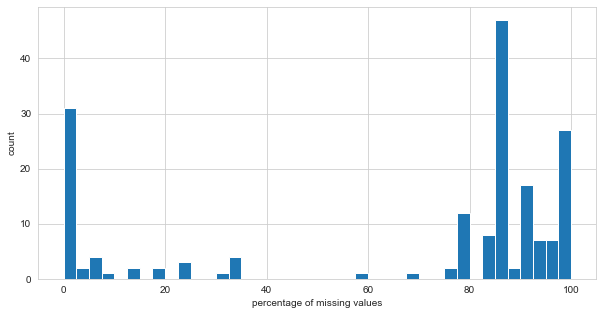

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(market_control_df["missing_percentage"], kde=False, bins = 40, hist_kws={"alpha":1})
plt.xlabel("percentage of missing values")
plt.ylabel("count");

Below, the output shows that 143 of the features with missing values are of type `float64`, while 20 of them are of type `object`.

In [13]:
market_control_df[market_control_df["missing"] != 0]["type"].value_counts()

float64    143
object      20
Name: type, dtype: int64

How many features have a percentage of missing values equal or higher than 50%?

In [14]:
market_control_df[(market_control_df["missing_percentage"] >= 50) & (market_control_df["type"] == "float64")].shape[0]

130

In [15]:
market_control_df[(market_control_df["missing_percentage"] >= 50) & (market_control_df["type"] == "object")].shape[0]

1

130 of the `float64` features and 1 `object` feature have 50% or more missing values. The decision, as a rule of thumb, is to drop these from the market dataset.

In [16]:
columns_to_drop = market_control_df[(market_control_df["missing_percentage"] >= 50)].index
market_df.drop(columns_to_drop, axis=1, inplace=True)
market_control_df = create_control_df(market_df)

print(f"The percentage of missing values in the market dataset is {round(100*(market_df.isna().sum().sum() / market_df.size))} %")

The percentage of missing values in the market dataset is 7 %


Later, the remaining missing values of each type of feature will be addressed.

### 2.4 Identifying ID features and constant features

The code below identifies features with a number equal to the number of observations (i.e. behaves as an ID for the companies), and features with constant observations (i.e. all observatios are equal, which will not help any model to generalize predictions/classifications/etc.).  
The feature `id` is the only one that behaves as an identifier to the companies. We'll assign it to a separate variable called `IDs`.  
The feature `fl_epp` is the only one that has equal values for each observation, thus it'll be dropped from the dataset.

In [17]:
id_features = list(market_control_df[market_control_df["unique"] == market_df.shape[0]].index)
constant_features = list(market_control_df[market_control_df["unique"] == 1].index)
print(f"The identifier feature{'s are' if len(id_features) > 1 else ' is'} {id_features}")
print(f"The constant feature{'s are' if len(constant_features) > 1 else ' is'} {constant_features}")

IDs = market_df[id_features]
market_df.drop(constant_features + id_features, axis=1, inplace=True)
market_control_df = create_control_df(market_df)

The identifier feature is ['id']
The constant feature is ['fl_epp']


Below, the unique values for each categorical variable is shown.  
The variable `dt_situacao` has too many classes for a categorical variable, this may cause problems later on while imputing values. The feature dictionary indicates that it represents dates when "de_situacao" was registered by the IRS, but it has no more references to "de_situacao", so we'll just drop it.

In [18]:
market_control_df.loc[(market_control_df["type"] == "object") | (market_control_df["type"] == "bool"), "unique"].sort_values(ascending=False).head()

features
dt_situacao             7334
nm_divisao                87
nm_micro_regiao           73
de_natureza_juridica      67
de_ramo                   33
Name: unique, dtype: int64

In [19]:
market_df.drop("dt_situacao", axis=1, inplace=True)

In [20]:
market_control_df.loc[(market_control_df["type"] == "float64") | (market_control_df["type"] == "int64"), "unique"].sort_values(ascending=False)

features
empsetorcensitariofaixarendapopulacao    15419
idade_empresa_anos                       14198
vl_faturamento_estimado_grupo_aux         6794
vl_faturamento_estimado_aux               1920
idade_media_socios                        1010
vl_total_veiculos_leves_grupo              310
qt_filiais                                 304
vl_total_veiculos_pesados_grupo            296
idade_maxima_socios                        118
idade_minima_socios                        114
qt_socios_pf                                64
qt_socios                                   62
qt_socios_st_regular                        54
nu_meses_rescencia                          51
qt_socios_pj                                12
Name: unique, dtype: int64

### 2.5 Verifying features' types

Next, we'll evaluate the features' characteristics and modify their types as necessary, and create lists with features' names by type.

In [21]:
market_control_df = create_control_df(market_df)

#### 2.5.1 Float features

In [22]:
market_control_df[market_control_df["type"] == "float64"]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
idade_empresa_anos,0,0.000,float64,14198,3.0712
vl_total_veiculos_pesados_grupo,1927,0.417,float64,296,0.0640
vl_total_veiculos_leves_grupo,1927,0.417,float64,310,0.0671
nu_meses_rescencia,45276,9.794,float64,51,0.0110
empsetorcensitariofaixarendapopulacao,143829,31.112,float64,15419,3.3353
qt_socios,115091,24.895,float64,62,0.0134
qt_socios_pf,115091,24.895,float64,64,0.0138
qt_socios_pj,115091,24.895,float64,12,0.0026
idade_media_socios,151602,32.793,float64,1010,0.2185


The code below assigns the names of float features to the list `float_features`, and the names if float features with missing values to `float_features_with_missing`. It also creates a table describing the float features.  
Checking their mean and median values through the next table, it's possible to infer that their distributions are right skewed (overall, means > medians).  
Also, the features `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios`, which represent ages, have negative minimum values.

In [23]:
float_features = list(market_control_df[market_control_df["type"] == "float64"].index)

float_features_with_missing = float_features.copy()
float_features_with_missing.remove("idade_empresa_anos")

market_df[float_features].describe()

features,idade_empresa_anos,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,empsetorcensitariofaixarendapopulacao,qt_socios,qt_socios_pf,qt_socios_pj,idade_media_socios,idade_maxima_socios,idade_minima_socios,qt_socios_st_regular,vl_faturamento_estimado_aux,vl_faturamento_estimado_grupo_aux
count,462298.000000,460371.000000,460371.000000,417022.000000,318469.000000,347207.000000,347207.000000,347207.000000,310696.000000,310696.000000,310696.000000,307381.000000,4.347850e+05,4.347850e+05
mean,9.948677,3.591801,48.699177,25.007247,1308.005725,1.496326,1.476681,0.019645,42.816452,44.344131,41.355225,1.396082,8.020911e+05,3.367205e+08
std,9.615664,72.600352,1206.696804,9.679799,1161.889222,3.276626,3.258079,0.195166,12.626447,13.930385,12.514921,2.578793,3.099979e+07,7.114614e+09
min,0.016438,0.000000,0.000000,0.000000,100.000000,1.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,1.000000,0.000000e+00,4.104703e+04
25%,2.756164,0.000000,0.000000,22.000000,673.230000,1.000000,1.000000,0.000000,33.000000,34.000000,32.000000,1.000000,1.648512e+05,1.854576e+05
50%,6.704110,0.000000,0.000000,23.000000,946.680000,1.000000,1.000000,0.000000,42.000000,43.000000,40.000000,1.000000,2.100000e+05,2.100000e+05
75%,14.465753,0.000000,0.000000,25.000000,1518.080000,2.000000,2.000000,0.000000,51.000000,54.000000,50.000000,1.000000,2.100000e+05,2.100000e+05
max,106.432877,9782.000000,122090.000000,66.000000,75093.840000,246.000000,246.000000,13.000000,127.000000,127.000000,127.000000,179.000000,1.454662e+10,2.227618e+11


In [24]:
def create_distplots(df, features):
    """
    Shows a grid with subplots containing the distribution plots for every feature in the list.
    :param df: Pandas DataFrame containing the data.
    :param features: list or similar containing the continuous numeric features names.
    """
    if len(features) == 1:
        plt.figure(figsize=(20, 4.3))
        sns.distplot(df[features[0]], hist_kws={"alpha":1}, kde=False)
        plt.xlabel(features[0])
        plt.ylabel("count")
    else:
        nrows = len(features)//2
        ncols = 2
        n_figures = len(features)-1
        if len(features) % 2 != 0:
            nrows += 1
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4.3))

        flag = 0
        while flag <= n_figures:
            for pos_row in range(nrows):
                for pos_col in range(ncols):
                    if nrows == 1:
                        ax = axs[pos_col]
                    else:
                        ax = axs[pos_row, pos_col]
                    if (len(features)%2 != 0) and (pos_row == nrows-1) and (pos_col == 1):
                        flag+=1
                        continue
                    sns.distplot(df[features[flag]], ax=ax, hist_kws={"alpha":1}, kde=False)
                    plt.xlabel(features[flag])
                    plt.ylabel("count")
                    flag+=1

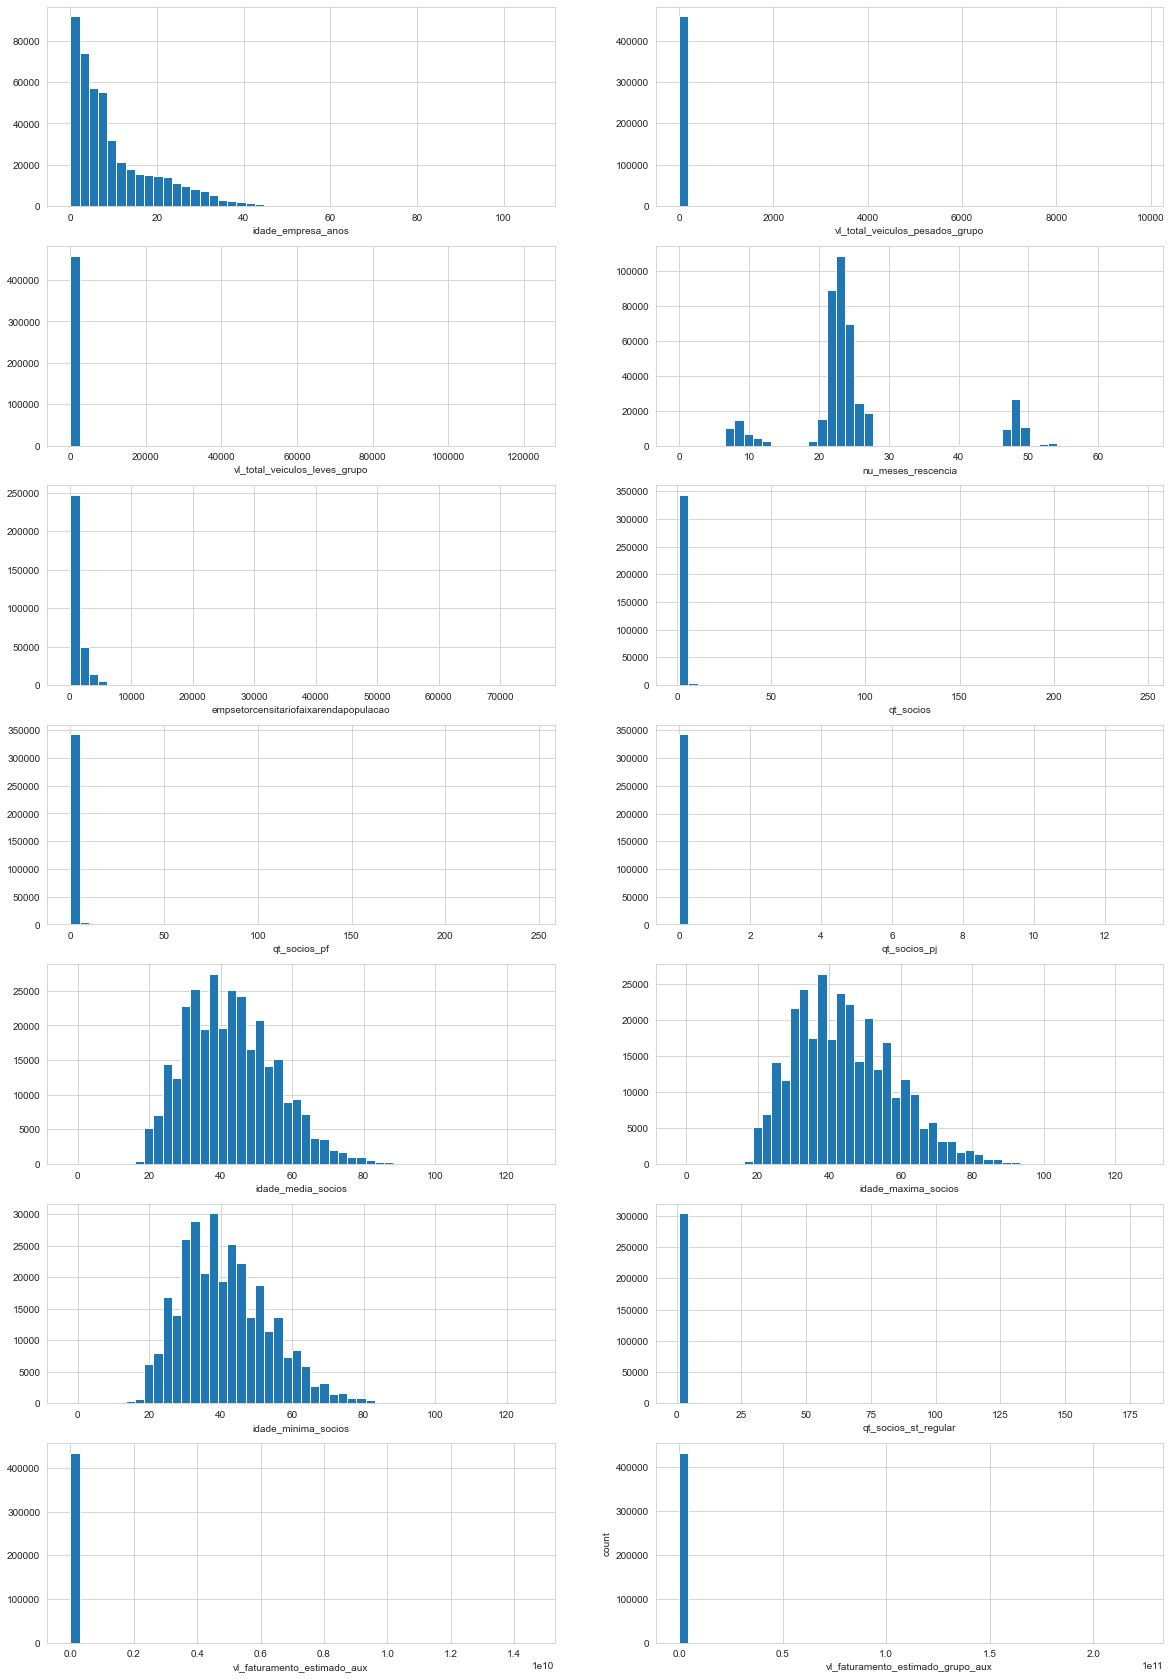

In [25]:
create_distplots(market_df, float_features)

Through the graphics and tables above it's possible to infer:  
* we confirm that the distributions are right skewed. Some have most values grouped together near 0.  
* Observing the x axis, it's possible to infer that some features present very extreme values.  
* The feature `nu_meses_rescencia` draws attention to it's three peaks, it's a multimodal distribution. 
* The features `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios` may be represented by a log-normal distribution.   
* Some present missing values.  

Since `idade_media_socios`, `idade_maxima_socios`, `idade_minima_socios` represent ages it should not have negative values. In the next code block we verify the most common values under 20, which seems like a good threshold considering the graphics, are also 20 - makes sense - we'll simply transform negative values into 20.

In [26]:
age_features = "idade_media_socios, idade_maxima_socios, idade_minima_socios".split(", ")
for feature in age_features:
    most_common_under_20 = market_df.loc[market_df[feature] <= 20, feature].value_counts().idxmax()
    print(f"{feature} most common under 20:\n{most_common_under_20}\n")
    market_df.loc[market_df[feature] <= 0, feature] = most_common_under_20 

idade_media_socios most common under 20:
20.0

idade_maxima_socios most common under 20:
20.0

idade_minima_socios most common under 20:
20.0



#### 2.5.2 Integer features

In [27]:
market_control_df[market_control_df["type"] == "int64"]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
qt_filiais,0,0.0,int64,304,0.0658


The code below assigns the name of integer features to the `integer_features` list. It also creates a table describing the feature.   
It's possible to infer that it's distributions is right skewed (overall, means > medians), much like the float features observed.  
There are no missing values in the feature.

In [28]:
integer_features = list(market_control_df[market_control_df["type"] == "int64"].index)

market_df[integer_features].describe()

features,qt_filiais
count,462298.000000
mean,28.737044
std,468.626094
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9647.000000


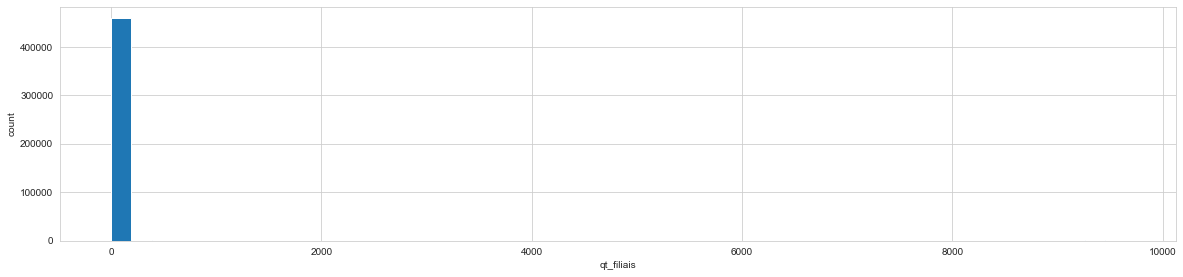

In [29]:
create_distplots(market_df, integer_features)

#### 2.5.3 Categorical features

In [30]:
market_control_df[(market_control_df["type"] == "object") | (market_control_df["type"] == "bool")]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
fl_matriz,0,0.000,bool,2,0.0004
de_natureza_juridica,0,0.000,object,67,0.0145
sg_uf,0,0.000,object,6,0.0013
natureza_juridica_macro,0,0.000,object,7,0.0015
de_ramo,0,0.000,object,33,0.0071
setor,1927,0.417,object,5,0.0011
idade_emp_cat,0,0.000,object,6,0.0013
fl_me,0,0.000,bool,2,0.0004
fl_sa,0,0.000,bool,2,0.0004


The table above shows that some features of type object have only two unique values. Usually, this is associated with boolean features. In the next code block we take a closer look and confirm that these are all actually boolean features. Their names' are stored in the `boolean_features` list, along with the features that were already of type bool, and the names of the boolean features with missing values are stored in `boolean_features_with_missing`.

In [31]:
boolean_features = list(market_control_df[
    ((market_control_df["type"] == "object") | (market_control_df["type"] == "bool"))
    & (market_control_df["unique"] == 2)].index)

boolean_features_with_missing = list(market_control_df[
    ((market_control_df["type"] == "object") | (market_control_df["type"] == "bool"))
    & (market_control_df["unique"] == 2) & (market_control_df["missing"] != 0)].index)

market_df[boolean_features].describe()

features,fl_matriz,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,fl_simples_irregular,fl_passivel_iss
count,462298,462298,462298,462298,462298,462298,462298,462298,462298,460371,460371,460371,379585,379585,460371,460371
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,True,False,False,False,False,False,False,True,NAO,False,False,False,True,False,False,True
freq,433232,461083,453866,311398,461056,462230,256228,335468,236779,460091,457095,429687,199617,285545,460030,264741


The boolean feature `fl_rm` is of type object and presents the top value as "NAO" ("NO" in portuguese). We'll transform this and the other boolean features into 0s and 1s.

In [32]:
temp_onehot = OneHotEncoder(drop="if_binary", sparse=False, dtype=np.float)
market_df.loc[:, "fl_rm"] = temp_onehot.fit_transform(market_df[["fl_rm"]])
market_df.loc[:, boolean_features] = market_df[boolean_features].astype(np.float)
market_df[boolean_features].describe()

features,fl_matriz,fl_me,fl_sa,fl_mei,fl_ltda,fl_st_especial,fl_email,fl_telefone,fl_rm,fl_spa,fl_antt,fl_veiculo,fl_optante_simples,fl_optante_simei,fl_simples_irregular,fl_passivel_iss
count,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,462298.000000,460371.000000,460371.000000,460371.000000,379585.000000,379585.000000,460371.000000,460371.000000
mean,0.937127,0.002628,0.018239,0.326413,0.002687,0.000147,0.445751,0.725653,0.487822,0.000608,0.007116,0.066651,0.525882,0.247744,0.000741,0.575060
std,0.242734,0.051198,0.133816,0.468901,0.051763,0.012127,0.497049,0.446185,0.499852,0.024654,0.084056,0.249416,0.499330,0.431703,0.027206,0.494334
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The remaining object features are described in the table below. Their names are stored as `object_features`, and the object features that have missing values are assigned to `object_features_with_missing`.

In [33]:
object_features = list(market_control_df[
    (market_control_df["type"] == "object") & (market_control_df["unique"] > 2)
].index)

object_features_with_missing = list(market_control_df[
    (market_control_df["type"] == "object") & (market_control_df["unique"] > 2) & (market_control_df["missing"] != 0)].index)

market_df[object_features].describe().T

,count,unique,top,freq
features,,,,
de_natureza_juridica,462298,67,EMPRESARIO INDIVIDUAL,295756
sg_uf,462298,6,MA,127654
natureza_juridica_macro,462298,7,OUTROS,320211
de_ramo,462298,33,COMERCIO VAREJISTA,172404
setor,460371,5,COMERCIO,211224
idade_emp_cat,462298,6,1 a 5,138580
nm_divisao,460371,87,COMERCIO VAREJISTA,172404
nm_segmento,460371,21,COMERCIO; REPARACAO DE VEICULOS AUTOMOTORES E ...,211224
sg_uf_matriz,460359,27,MA,124823


In [34]:
def create_barplots(df, features, n_labels=None):
    """
    Shows a grid with subplots containing barplots for every feature in the list.
    :param df: Pandas DataFrame containing the data.
    :param features: list or similar containing the categorical features names.
    :param n_labels: integer, representes number of features' labels to plot. Uses the n features with more counts in descending order.
    """    
    if len(features) == 1:
        x = df[features].value_counts().head(n_labels)
        y = x.index        
        plt.figure(figsize = (25, 4.3))
        sns.barplot(x = x, y = y)
        plt.xlabel(features[0])
    else:
        n_figures = len(features) - 1
        nrows = len(features)//2
        ncols = 2
        if len(features) % 2 != 0:
            nrows += 1
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows*4.5))
        plt.subplots_adjust(wspace=1.25)
        
        flag = 0
        while flag <= n_figures:
            for pos_row in range(nrows):
                for pos_col in range(ncols):
                    if nrows == 1:
                        ax = axs[pos_col]
                    else:
                        ax = axs[pos_row, pos_col]
                    if (len(features)%2 != 0) and (pos_row == nrows-1) and (pos_col == 1):
                        flag+=1
                        continue
                    x = df[features[flag]].value_counts().head(n_labels)
                    y = x.index
                    sns.barplot(x=x, y=y, ax=ax)
                    plt.xlabel(features[flag])
                    flag+=1

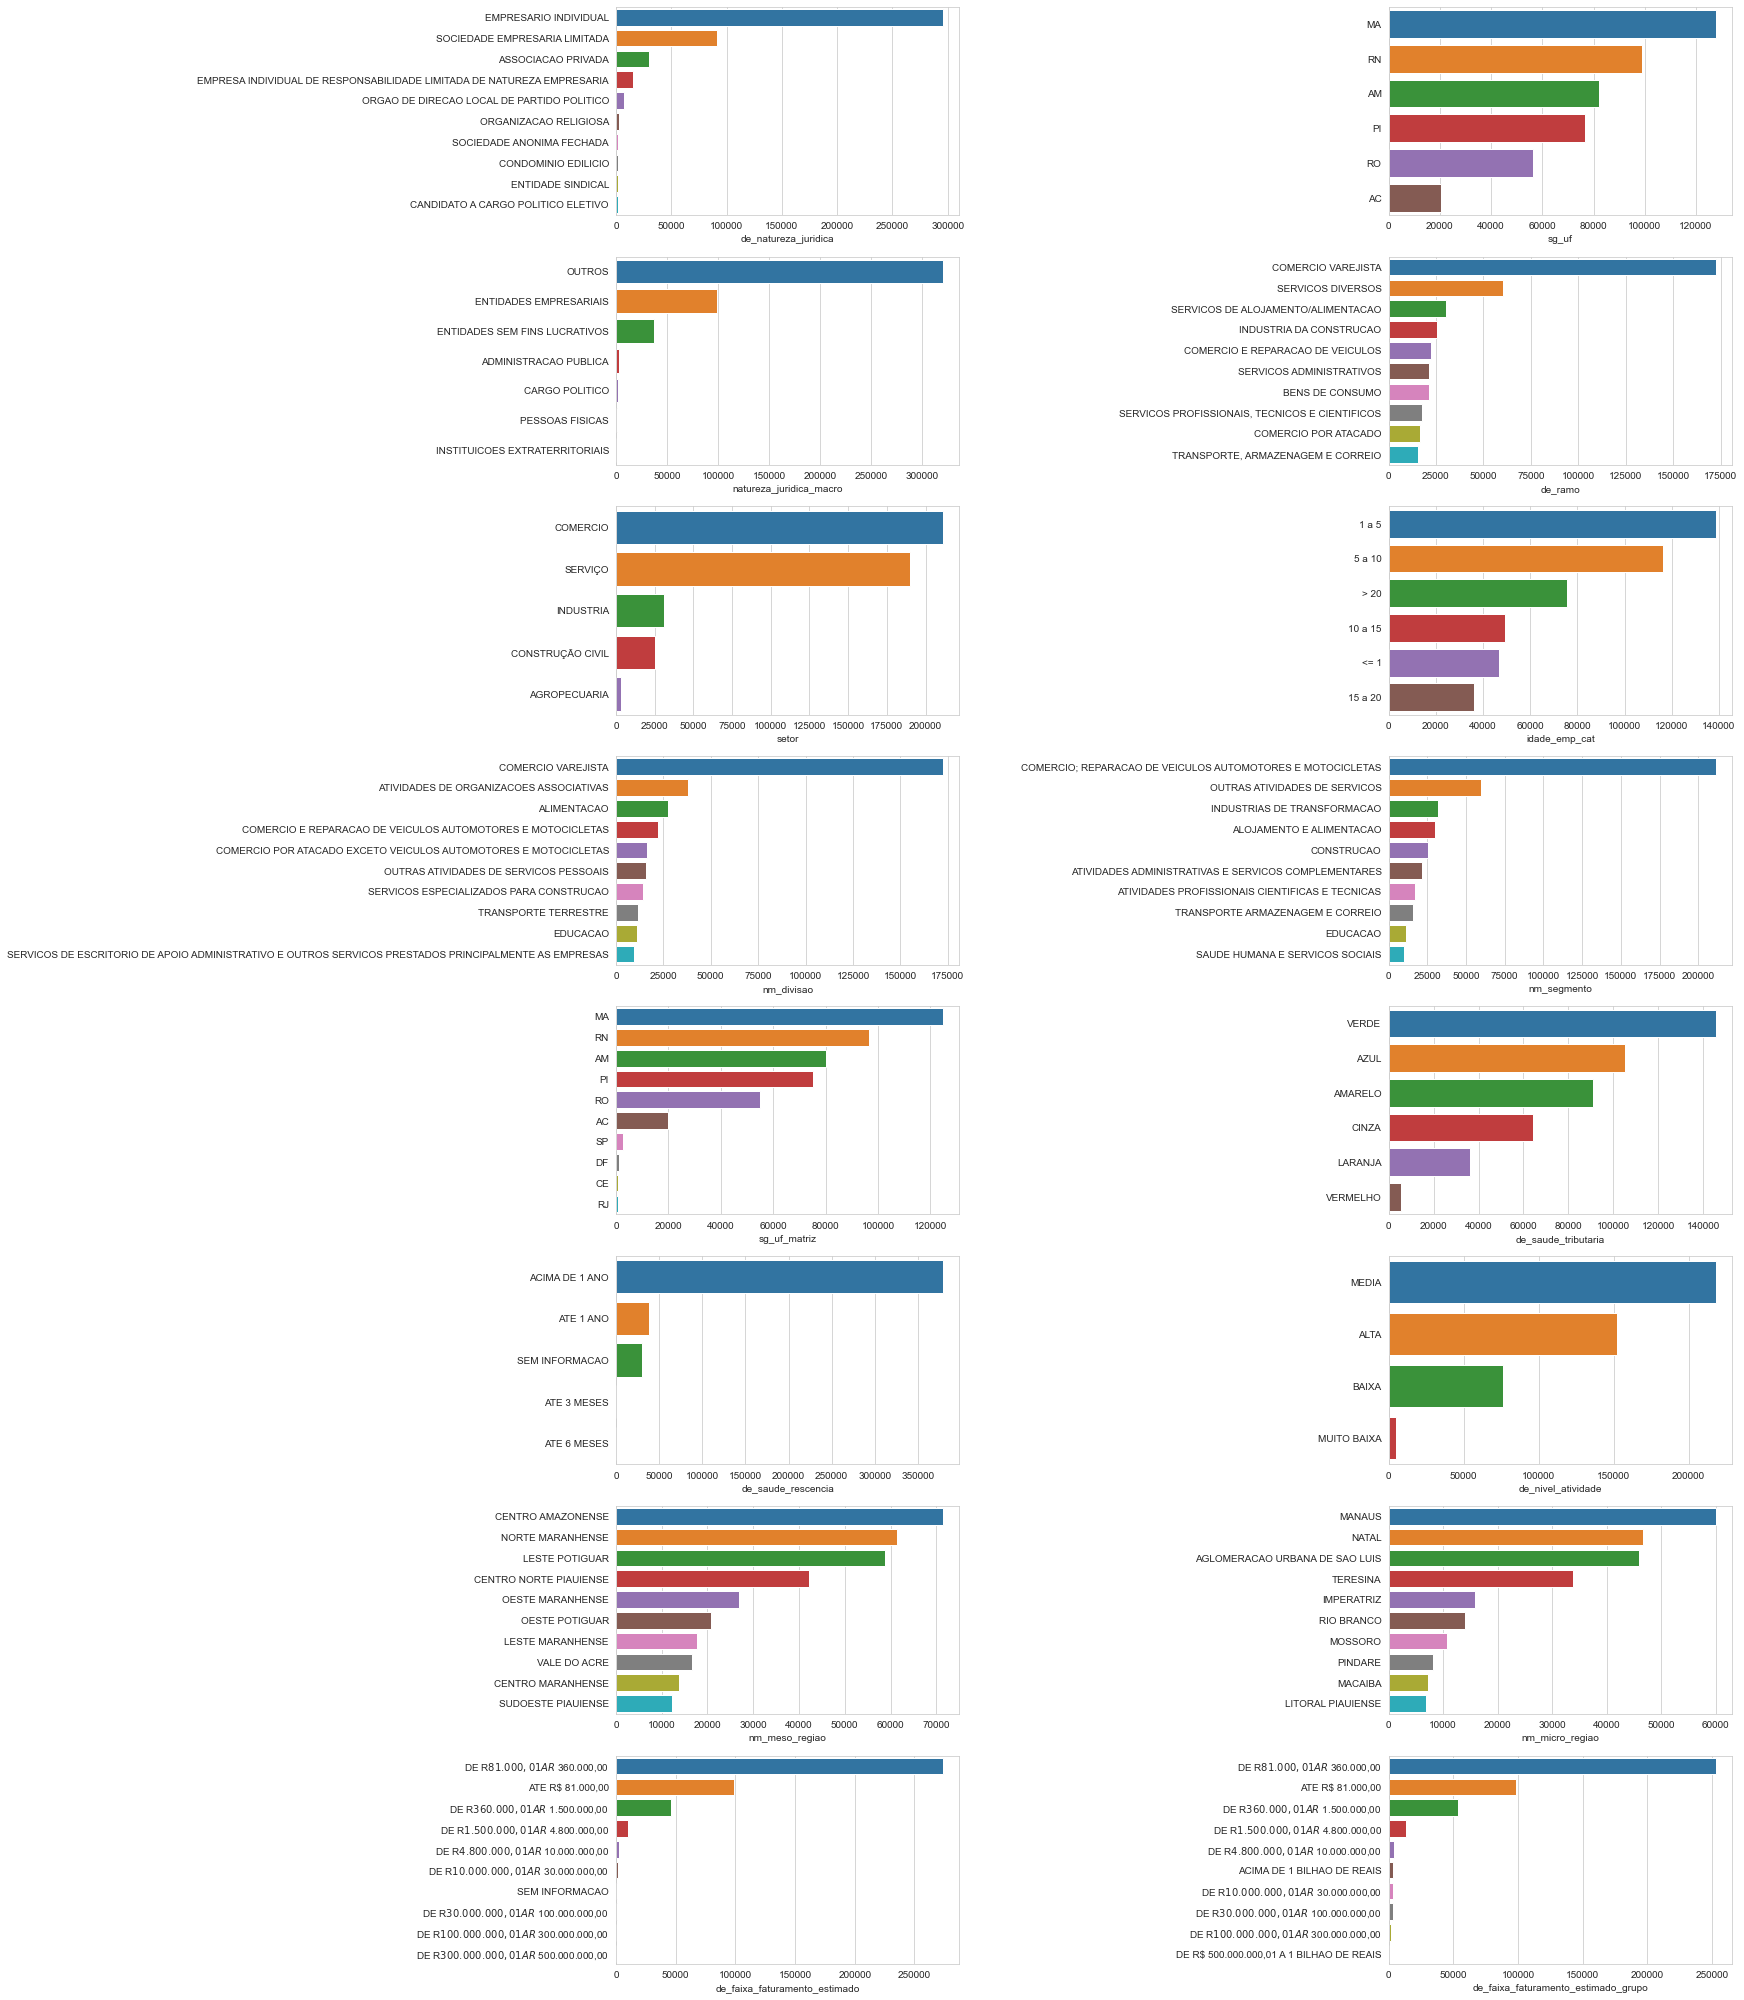

In [35]:
create_barplots(market_df, object_features, n_labels=10)

### 2.6 Imputing Missing Values

Below, it can be seen through the graphic that some remaining features have at least around 35% missing values or less.

In [36]:
market_control_df = create_control_df(market_df)

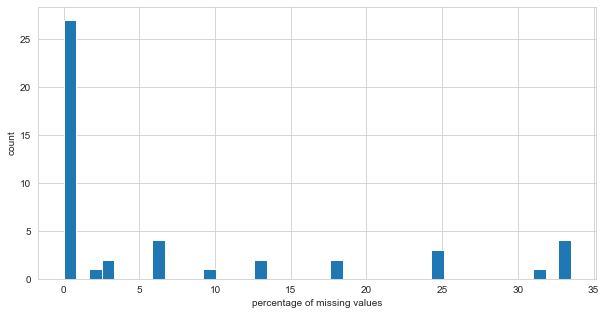

In [37]:
plt.figure(figsize=(10,5))
sns.distplot(market_control_df["missing_percentage"], kde=False, bins = 40, hist_kws={"alpha":1})
plt.xlabel("percentage of missing values")
plt.ylabel("count");

The next output shows that from the remaining 32 features with missing values, 20 are of type `float64`, while 12 of them are of type `object`. Remember that the boolean features were turned into the type float, but they should be treated as categorical.

In [38]:
print(f"From the {market_control_df.shape[0]} remaining features, {market_control_df[market_control_df['missing'] !=0 ].shape[0]} have missing values.")
print(f"\nTheir types are:\n{market_control_df[market_control_df['missing'] != 0]['type'].value_counts()}")

From the 47 remaining features, 31 have missing values.

Their types are:
float64    20
object     11
Name: type, dtype: int64


#### 2.6.1 Missing values of numeric features
The folowing table shows the remaining `float64` features and their respective count and percentage of missing values.

In [39]:
market_control_df[(market_control_df["type"] == "float64")].sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
qt_socios_st_regular,154917,33.510,float64,54,0.0117
idade_minima_socios,151602,32.793,float64,113,0.0244
idade_maxima_socios,151602,32.793,float64,117,0.0253
idade_media_socios,151602,32.793,float64,1009,0.2183
empsetorcensitariofaixarendapopulacao,143829,31.112,float64,15419,3.3353
qt_socios_pj,115091,24.895,float64,12,0.0026
qt_socios_pf,115091,24.895,float64,64,0.0138
qt_socios,115091,24.895,float64,62,0.0134
fl_optante_simei,82713,17.892,float64,2,0.0004


First, we'll impute the missing values with the features' medians, and check their distributions again.

In [40]:
market_df_copy = market_df.copy()

In [41]:
float_imputer = SimpleImputer(strategy="median")
market_df_copy[float_features] = float_imputer.fit_transform(market_df_copy[float_features])

Comparing the distributions from the plots above and below, before and after imputing missing values with the features' medians, we see that some features present too many counts on the features' means - there were too many missing values and this approach may be to simple for some of the features.  

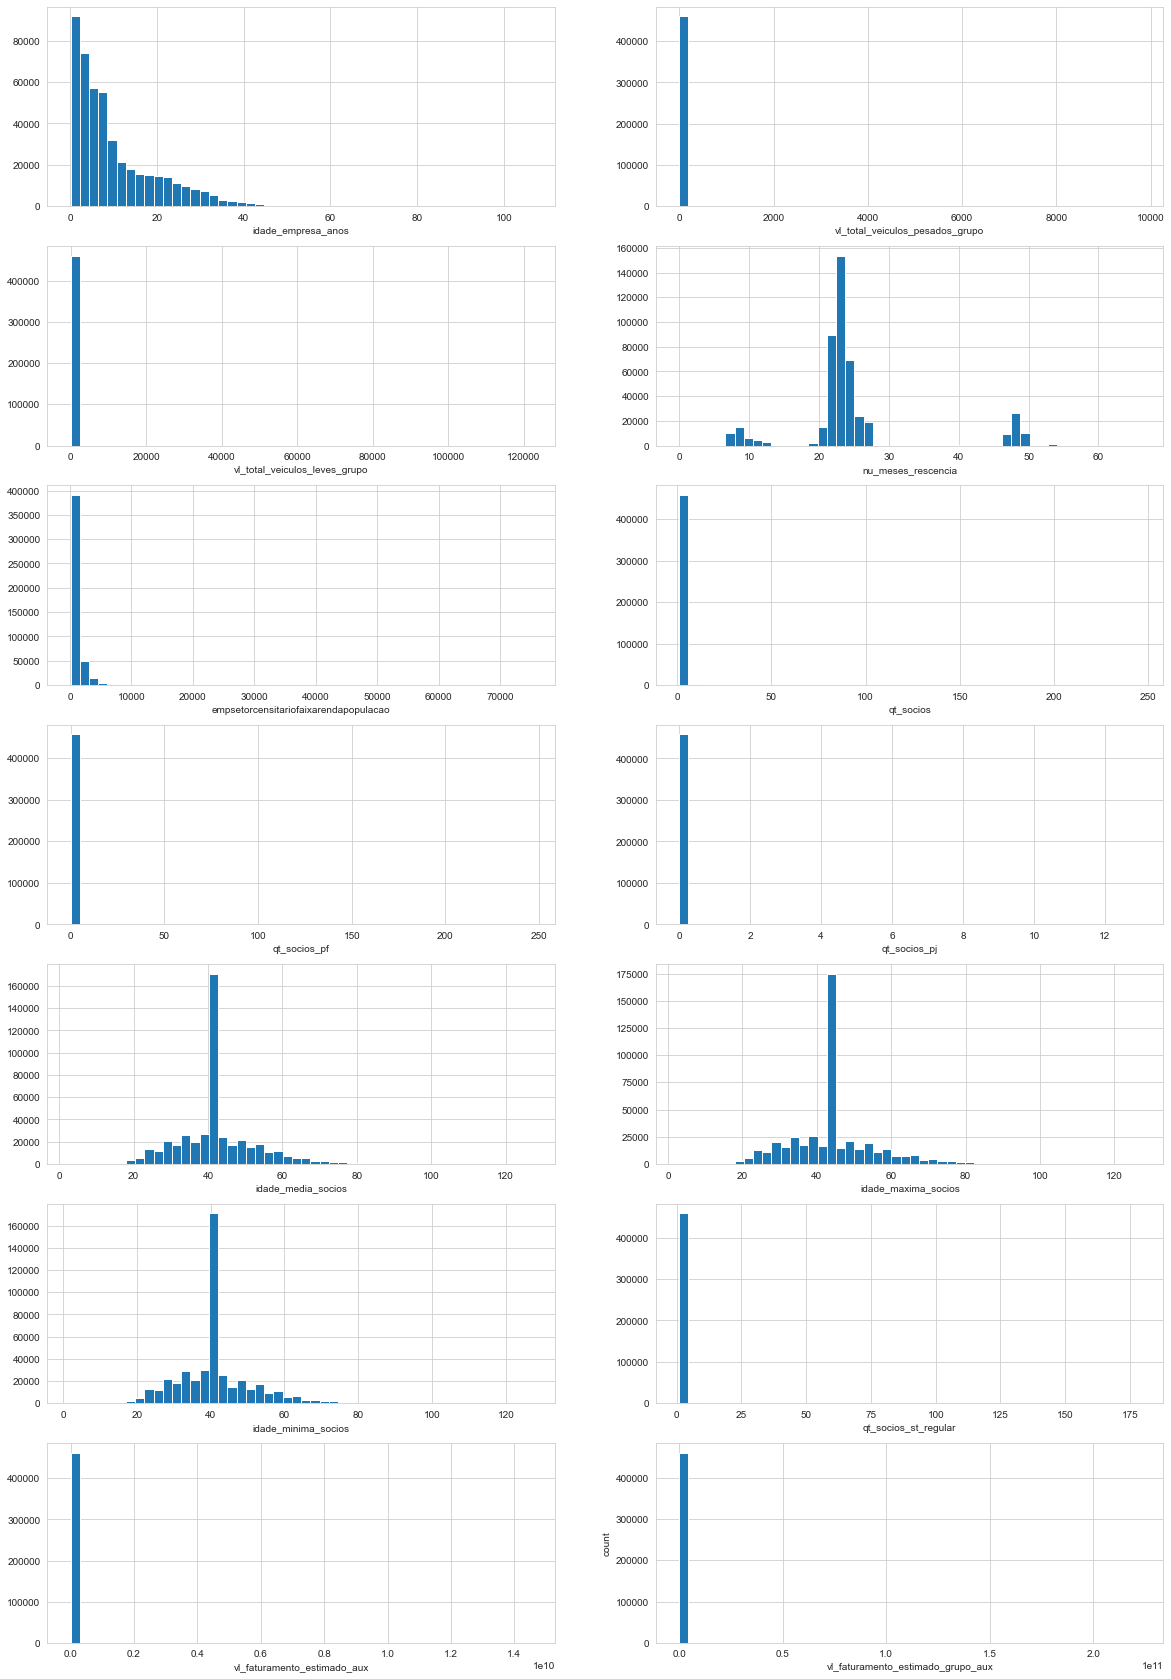

In [42]:
create_distplots(market_df_copy, float_features)

The features in which the median imputation showed too gross changes, mainly:  
* `nu_meses_rescencia`  
* `empsetorcensitariofaixarendapopulacao`
* `idade_media_socios`
* `idade_maxima_socios`
* `idade_minima_socios`  

The next code block presents a function to create vectors of values to impute in the features with missing values. To estimate the values, the features that do not have any missing values are used. Random Forests is used as regressor.

In [43]:
def impute_value_generator(df, targets, numeric_predictors, categorical_predictors, target_type="numeric", sample_size=5000):
    """
    Create a dictionary with each target feature as key. Each feature dictionary has, in turn, keys for the values created to impute the missing values\n
from the feature, and keys for the metrics generated. It can be used for numeric or categorical targets, and the sample size can be selected to improve\n
iteration speed.
    :param df: Pandas DataFrame that contains the data from the targets and predictors.
    :param targets: list or similiar, contains the names of the features for which the values will be created and appended to the output dictionary.
    :param numeric_predictors: list or similar, contains the names of the numeric features that will be used to predict/classify the missing values. \n
The predictors shouldn't contain missing values.
    :param categorical_predictors: list or similar, contains the names of the categorical features that will be used to predict/classify the missing values. \n
The predictors shouldn't contain missing values.
    :param target_type: string, accepts the values "numeric" and "categorical". It's used to select the pipeline to be applied - regresion or classification.
    :param sample_size: integer, represents the sample size used by the function. It's used to reduce the number of observations used by the function\n
thus speeding the iterations.
    :return: A dictionary which contains keys for each target. These have, in turn, keys for the impute values and for the metrics generated.
    """
    output = {}
     
    for target in targets:
        print(f"Executing iteration for {target}")
        
        # Sciki-learn pipeline and column transformer
        cat_pipeline = Pipeline(steps=[
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

        num_pipeline = Pipeline(steps=[
            ("standardizer", StandardScaler())
        ])

        transformer = ColumnTransformer(transformers=[
            ("categorical", cat_pipeline, categorical_predictors),
            ("numeric", num_pipeline, numeric_predictors)
        ])
        
        if target_type == "numeric":
            pipeline = Pipeline(steps=[
                ("transformer", transformer),
                ("regressor", RandomForestRegressor(n_jobs=-1))
            ])

        elif target_type == "categorical":            
            pipeline = Pipeline(steps=[
                ("transformer", transformer),
                ("classifier", RandomForestClassifier(n_jobs=-1))
            ])

        else:
            raise Exception("'target_type' must be either 'numeric' or 'categorical'")
        
        sample_features = numeric_predictors + categorical_predictors
        
        # Getting observations without missing values
        sample_df = df.loc[~df[target].isna(), sample_features + [target]].reset_index(drop=True)

        # Getting another sample of inferior size to speed up training. The indexes are chosen at random.
        idx = np.random.choice(len(sample_df), size=sample_size, replace=False)
        
        # Target and predictor assignment
        X = sample_df.drop(target, axis=1).iloc[idx]
        y = sample_df[target].iloc[idx]
        if target_type == "categorical":
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(y)

        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Fit the model and predict for test set
        pipeline.fit(X_train, y_train)
        prediction = pipeline.predict(X_test)                
        
        # Create variables to impute the missing values. The length of the created vector is equal to the number of missing values in the target
        # Getting a sample from the observations where the target variable is missing
        target_missing_sample = df.loc[df[target].isna(), sample_features].reset_index(drop=True)
        impute_variables = pipeline.predict(target_missing_sample)
        
        # Save created values, evaluate the prediction/classification for each feature, and save metrics
        if target_type == "numeric":            
            output.update({target: {
                "impute_variables": impute_variables,
                "mean_absolute_error": mean_absolute_error(prediction, y_test).round(2),
                "root_mean_squared_error": np.sqrt(mean_squared_error(prediction, y_test)).round(2),
                "pipeline": pipeline
            }})
            print(f"Metrics:\nmean absolute error: {output[target]['mean_absolute_error']}\n\
root mean squared error: {output[target]['root_mean_squared_error']}")
            print(169*"-")
            
        elif target_type == "categorical":
            output.update({target: {
                "impute_variables": impute_variables,
                "accuracy_score": accuracy_score(prediction, y_test).round(2),
                "f1_score": f1_score(prediction, y_test, average="weighted").round(2),
                "confusion_matrix": confusion_matrix(prediction, y_test),
                "classification_report": classification_report(prediction, y_test, zero_division=0),
                "pipeline": pipeline,
                "label_encoder": label_encoder
            }})
            print(f"Metrics:\naccuracy: {output[target]['accuracy_score']}\n\
Weighted F1 score: {output[target]['f1_score']}")
            print(169*"-")
            
    return output

In [44]:
market_df_copy = market_df.copy() # making another copy to ignore previous imputation

In [45]:
# defining lists with the names of features without missing values.

object_features_without_missing = [feature for feature in object_features if (feature not in object_features_with_missing)]
boolean_features_without_missing = [feature for feature in boolean_features if (feature not in boolean_features_with_missing)]
float_features_without_missing = [feature for feature in float_features if (feature not in float_features_with_missing)]
# integer_features is already defined and it doesn't containt missing values
numeric_features_without_missing = float_features_without_missing + integer_features
categorical_features_without_missing = object_features_without_missing + boolean_features_without_missing

# defining lists with the names numeric and categorical features.
numeric_features = float_features + integer_features
categorical_features = object_features + boolean_features

print(f"Numeric features without missing values:\n{numeric_features_without_missing}\n\
Categorical features without missing values:\n{categorical_features_without_missing}\n")

Numeric features without missing values:
['idade_empresa_anos', 'qt_filiais']
Categorical features without missing values:
['de_natureza_juridica', 'sg_uf', 'natureza_juridica_macro', 'de_ramo', 'idade_emp_cat', 'fl_matriz', 'fl_me', 'fl_sa', 'fl_mei', 'fl_ltda', 'fl_st_especial', 'fl_email', 'fl_telefone', 'fl_rm']



Below, the function is applied to the numeric features, and generates values to be imputed. The features used for the prediciton are the numeric and categorical features without missing values, seen above.  

In [46]:
%%time
numeric_impute_dict = impute_value_generator(df=market_df_copy,
                                             targets=float_features_with_missing, 
                                             numeric_predictors=numeric_features_without_missing,
                                             categorical_predictors=categorical_features_without_missing,
                                             target_type="numeric",
                                             sample_size=25000) # 50000

Executing iteration for vl_total_veiculos_pesados_grupo
Metrics:
mean absolute error: 1.19
root mean squared error: 18.03
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for vl_total_veiculos_leves_grupo
Metrics:
mean absolute error: 13.3
root mean squared error: 465.73
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nu_meses_rescencia
Metrics:
mean absolute error: 4.58
root mean squared error: 7.87
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for empsetorcensitariofaixarendapopulacao
Metrics:
mean absolute error: 689.39
root mean squared error: 1070.1
--------

Next, we plot the numeric values to be imputed. The features that present the higher error rates, as seen above, also present distributions that are quite similar to the ones obtained through the use of median imputation. 

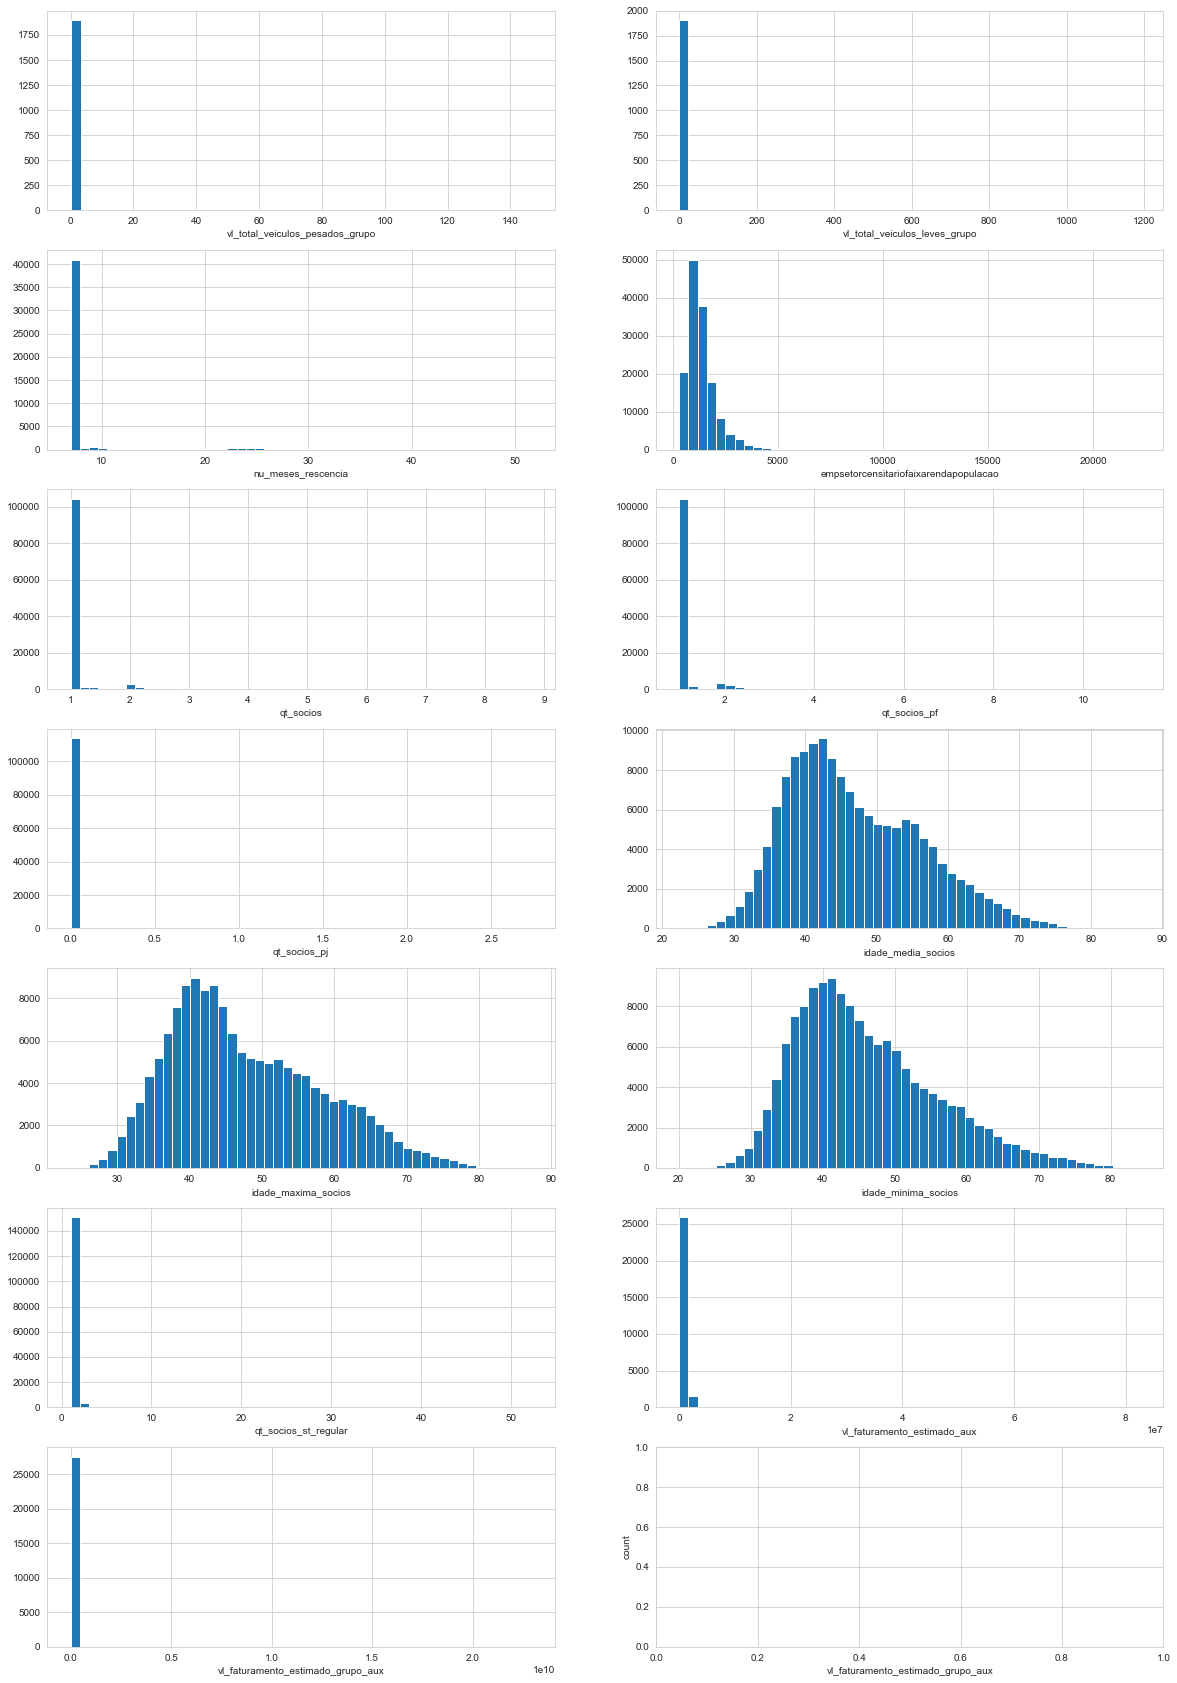

In [47]:
numeric_impute_df = pd.DataFrame({feature: pd.Series(numeric_impute_dict[feature]["impute_variables"]) for feature in [feature for feature in numeric_impute_dict.keys()]})

create_distplots(numeric_impute_df, numeric_impute_df.columns)

The next code block impute the missing values generated (they were created in sequence, so they'll match the missing values' positions), and creates yet another plot of all the float features without missing values - e.g. already imputed.

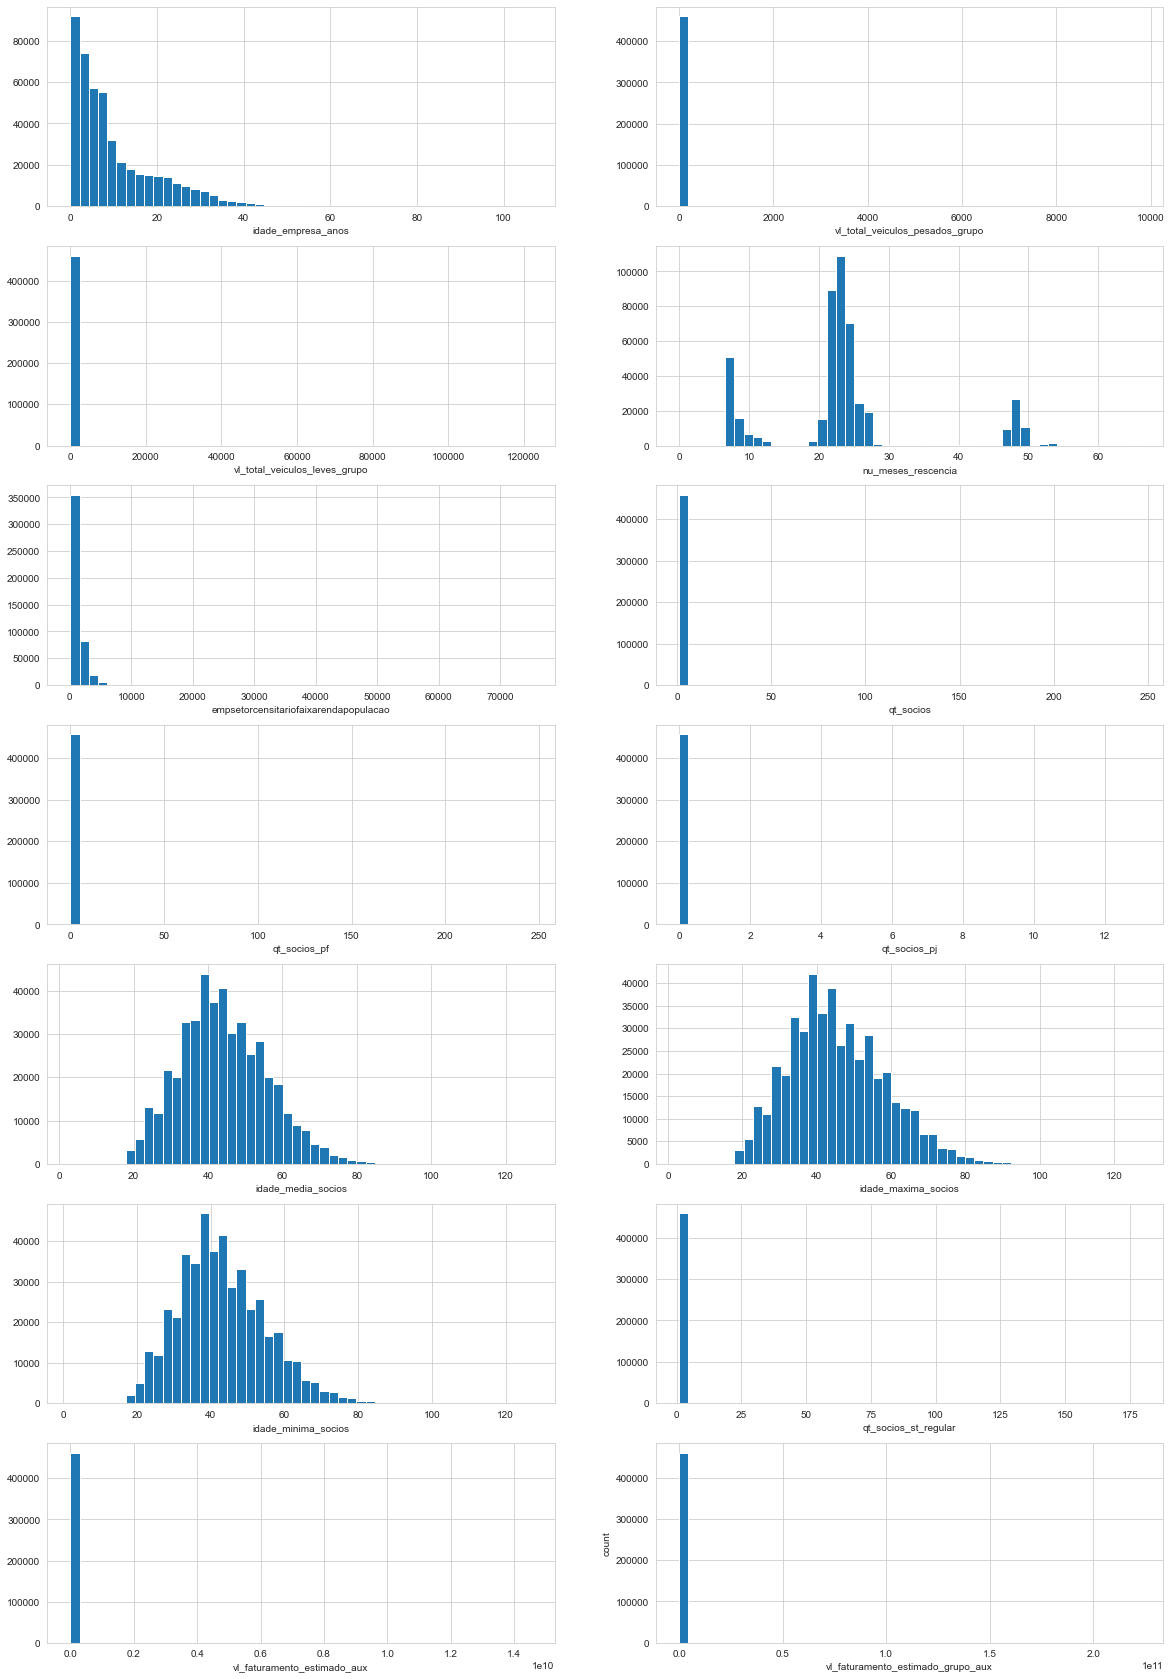

In [48]:
for feature in float_features_with_missing:
    market_df_copy.loc[market_df_copy[feature].isna(), feature] = numeric_impute_dict[feature]["impute_variables"]
create_distplots(market_df_copy, float_features)

The float features distributions with imputed missing values are now behaving simmilarly to the original distributions. The table below shows that there are no missing values among the `float64` features.

In [49]:
market_control_df = create_control_df(market_df_copy)
market_control_df.loc[float_features, :]

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
idade_empresa_anos,0,0.0,float64,14198,3.0712
vl_total_veiculos_pesados_grupo,0,0.0,float64,384,0.0831
vl_total_veiculos_leves_grupo,0,0.0,float64,455,0.0984
nu_meses_rescencia,0,0.0,float64,1255,0.2715
empsetorcensitariofaixarendapopulacao,0,0.0,float64,126242,27.3075
qt_socios,0,0.0,float64,447,0.0967
qt_socios_pf,0,0.0,float64,568,0.1229
qt_socios_pj,0,0.0,float64,127,0.0275
idade_media_socios,0,0.0,float64,54243,11.7333


#### 2.6.2 Missing Values of Categorical Features
The following code blocks presents the remaining categorical features (of type object and bool), and their respective count and percentage of missing values.

In [50]:
pd.concat([market_control_df.loc[object_features], market_df[object_features].describe().T[["count", "top", "freq"]]], axis=1).sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage,count,top,freq
features,,,,,,,,
nm_meso_regiao,58698,12.697,object,19,0.0041,403600,CENTRO AMAZONENSE,71469
nm_micro_regiao,58698,12.697,object,73,0.0158,403600,MANAUS,60008
de_faixa_faturamento_estimado,27513,5.951,object,12,0.0026,434785,"DE R$ 81.000,01 A R$ 360.000,00",273861
de_faixa_faturamento_estimado_grupo,27513,5.951,object,11,0.0024,434785,"DE R$ 81.000,01 A R$ 360.000,00",252602
de_saude_tributaria,14851,3.212,object,6,0.0013,447447,VERDE,145430
de_saude_rescencia,14851,3.212,object,5,0.0011,447447,ACIMA DE 1 ANO,378896
de_nivel_atividade,11168,2.416,object,4,0.0009,451130,MEDIA,217949
sg_uf_matriz,1939,0.419,object,27,0.0058,460359,MA,124823
setor,1927,0.417,object,5,0.0011,460371,COMERCIO,211224


In [51]:
market_control_df.loc[boolean_features].sort_values(by="missing", ascending=False)

,missing,missing_percentage,type,unique,unique_percentage
features,,,,,
fl_optante_simples,82713,17.892,float64,2,0.0004
fl_optante_simei,82713,17.892,float64,2,0.0004
fl_spa,1927,0.417,float64,2,0.0004
fl_antt,1927,0.417,float64,2,0.0004
fl_veiculo,1927,0.417,float64,2,0.0004
fl_simples_irregular,1927,0.417,float64,2,0.0004
fl_passivel_iss,1927,0.417,float64,2,0.0004
fl_matriz,0,0.000,float64,2,0.0004
fl_me,0,0.000,float64,2,0.0004


Simmilarly to the imputation done to fhe numeric features, we'll use random forests to classify the missing values. As predictors, this time we'll use all the numeric features, in which values have been imputed, and the categorical features without missing values.

In [52]:
categorical_features_with_missing = object_features_with_missing + boolean_features_with_missing
print(f"Categorical features with missing values:\n{categorical_features_with_missing}")

Categorical features with missing values:
['setor', 'nm_divisao', 'nm_segmento', 'sg_uf_matriz', 'de_saude_tributaria', 'de_saude_rescencia', 'de_nivel_atividade', 'nm_meso_regiao', 'nm_micro_regiao', 'de_faixa_faturamento_estimado', 'de_faixa_faturamento_estimado_grupo', 'fl_spa', 'fl_antt', 'fl_veiculo', 'fl_optante_simples', 'fl_optante_simei', 'fl_simples_irregular', 'fl_passivel_iss']


In [53]:
%%time
categorical_impute_dict = impute_value_generator(df=market_df_copy,
                                                 targets=categorical_features_with_missing,
                                                 numeric_predictors=numeric_features,
                                                 categorical_predictors=categorical_features_without_missing,
                                                 target_type='categorical',
                                                 sample_size=25000) # 50000

Executing iteration for setor
Metrics:
accuracy: 0.99
Weighted F1 score: 0.99
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nm_divisao
Metrics:
accuracy: 0.87
Weighted F1 score: 0.88
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for nm_segmento
Metrics:
accuracy: 1.0
Weighted F1 score: 1.0
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Executing iteration for sg_uf_matriz
Metrics:
accuracy: 0.98
Weighted F1 score: 0.99
------------------------------------------------------------------------------------------------------------------------------------------------------------------

Next, the categorical features with missing values are imputed and countplots are generated.

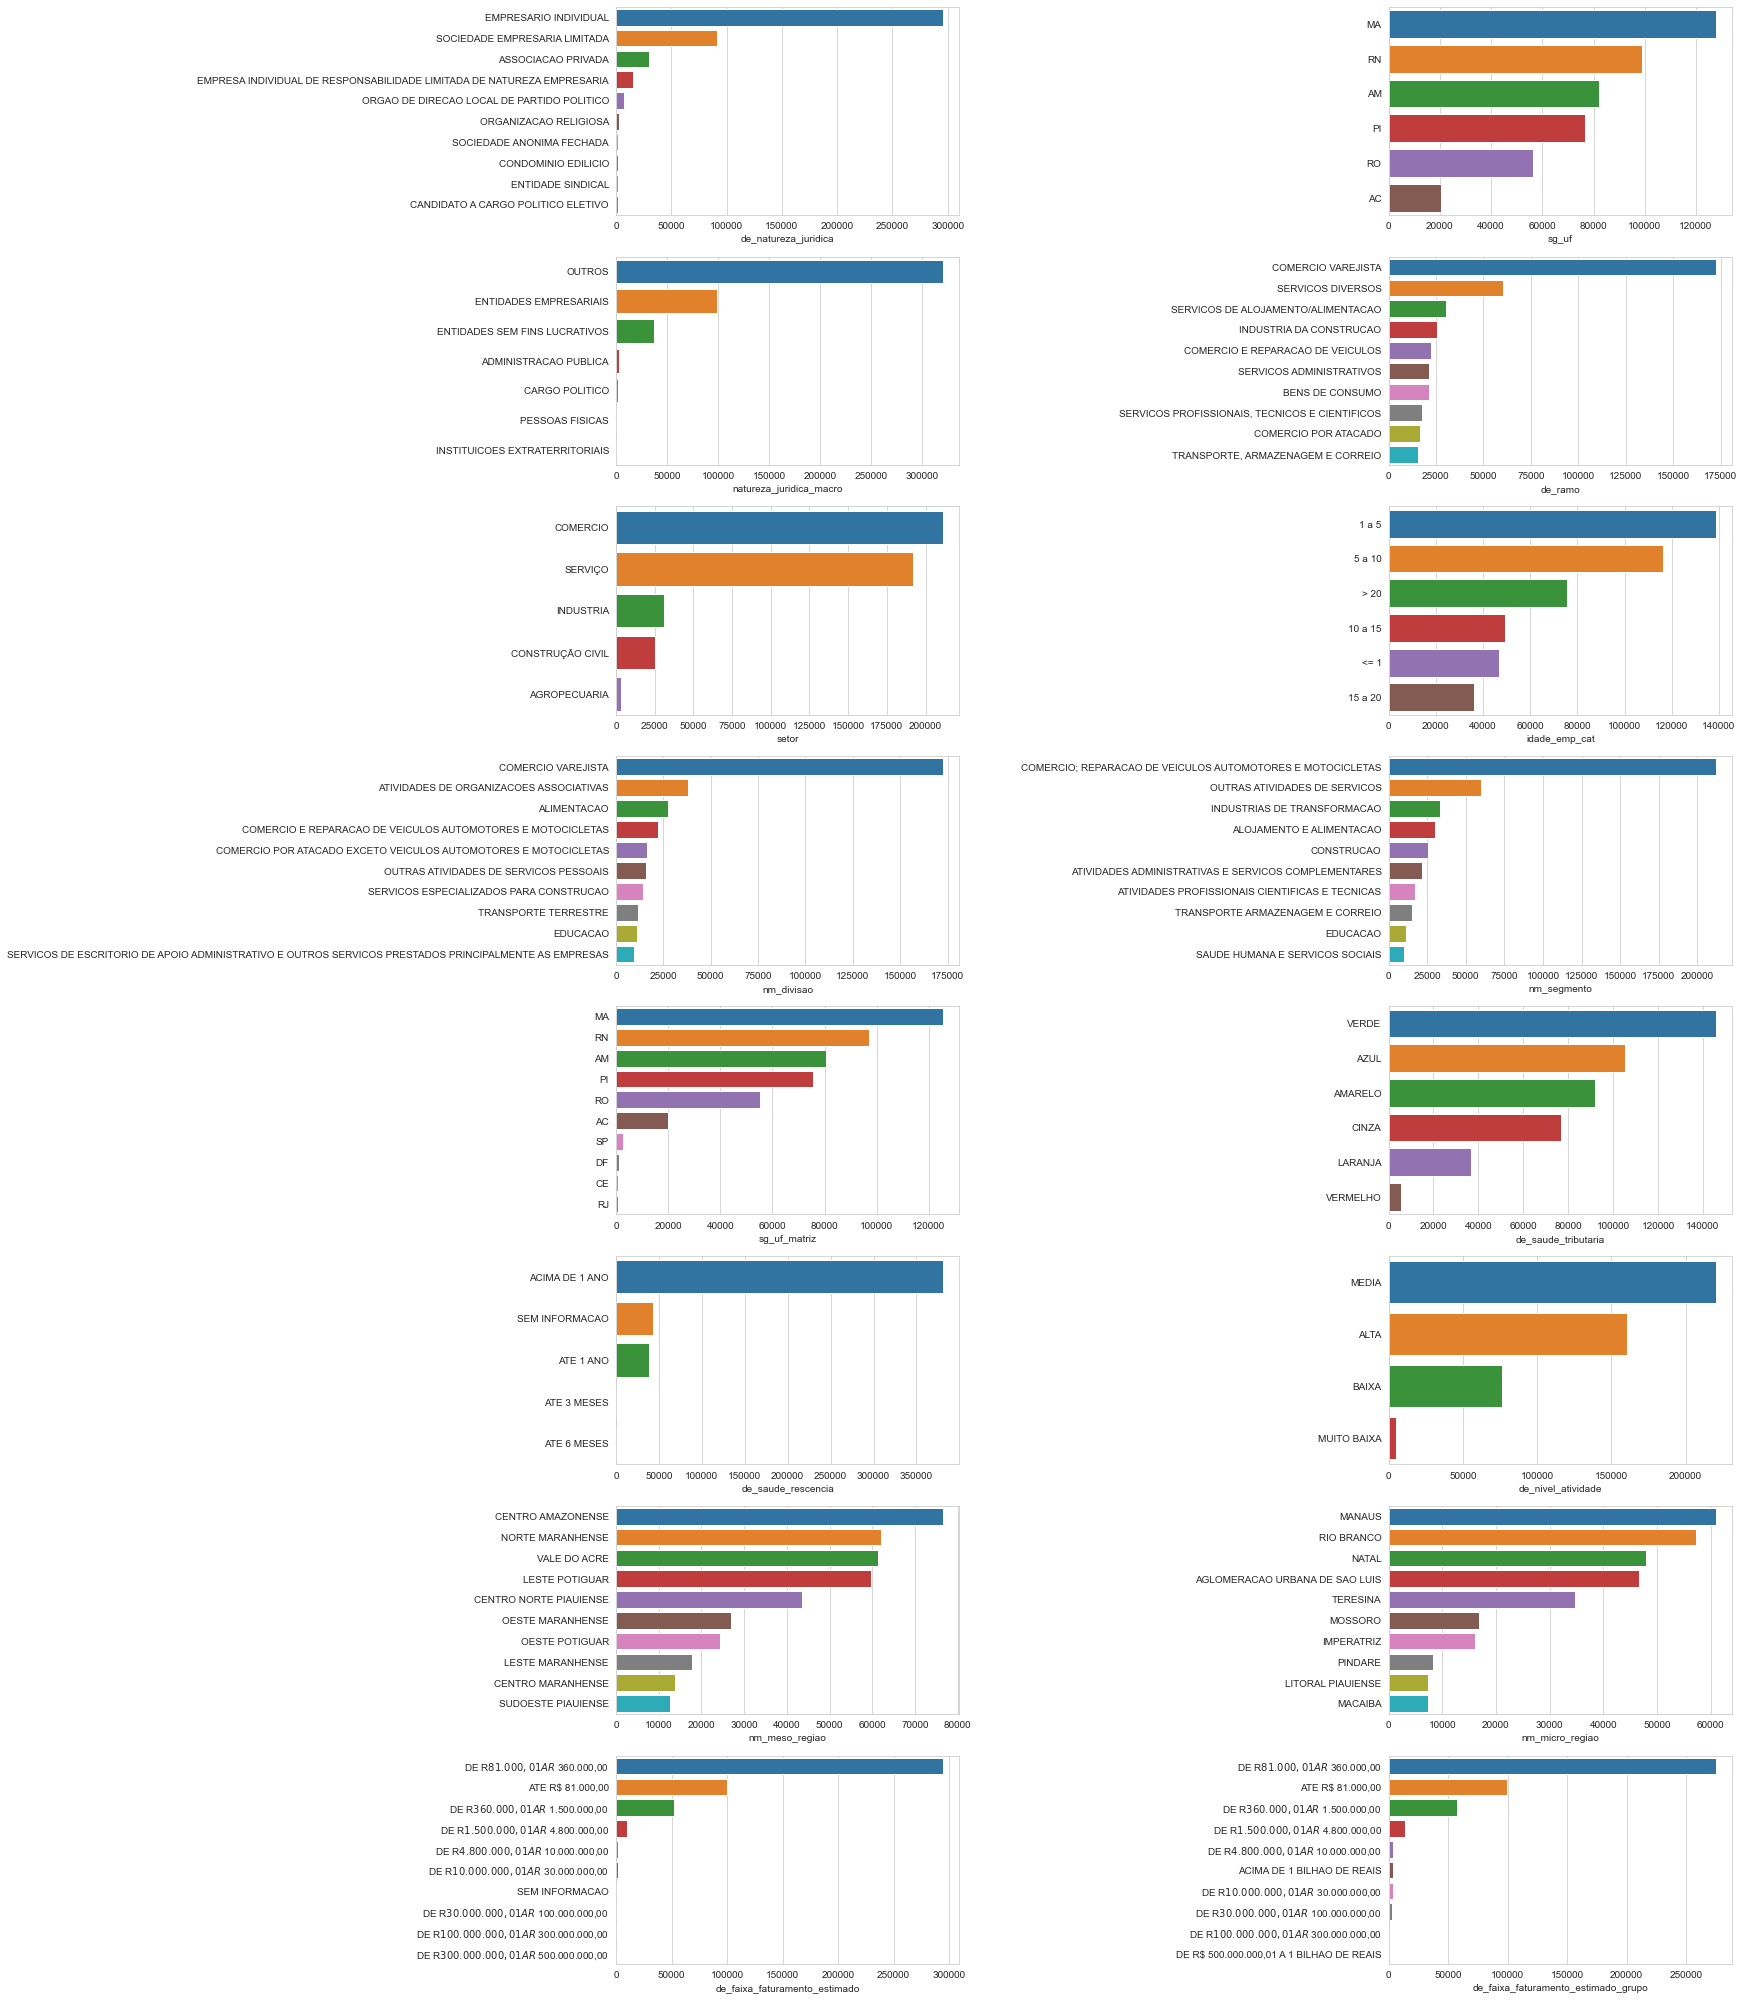

In [54]:
for feature in categorical_features_with_missing:
    # Re-transforming the predicted classes from numbers to labels.
    _to_impute = categorical_impute_dict[feature]["label_encoder"].inverse_transform(categorical_impute_dict[feature]["impute_variables"])
    market_df_copy.loc[market_df_copy[feature].isna(), feature] = _to_impute
create_barplots(market_df_copy, object_features, n_labels=10)

The result printed next shows that there are no more missing values in our dataset.

In [55]:
print(f"The percentage of missing values in the market dataset is {round(100*(market_df_copy.isna().sum().sum() / market_df_copy.size))} %")

The percentage of missing values in the market dataset is 0 %


### 2.7 Feature Selection
In the next step we try to reduce our feature space by using a feature selection technique that can deal with sparse matrices. It's possible to see through the plot below, though, that to obtain close to 95% of explained variance ratio, it'll be necessary to maintain all 47 features.

In [59]:
def truncated_SVD_selector(df, numeric_features, categorical_features, n_components=None):
    """
    Feature selection by the use of truncatedSVD.
    :param df: Pandas DataFrame with the data for the feature selection to be applied.
    :param numeric_features: list, must contain names of the numeric features in the dataset.
    :param categorical_features: list, must contain names of the categorical features in the dataset.
    :param n_components: integer, number of features to maintain.
    :return: array containing the number of features defined with n_components and the pipeline used to process the features.
    """
    if not n_components:
        n_components = df.shape[1]
    
    # Sciki-learn pipeline and column transformer
    cat_pipeline = Pipeline(steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    num_pipeline = Pipeline(steps=[
        ("standardizer", StandardScaler())
    ])
    
    transformer = ColumnTransformer(transformers=[
        ("categorical", cat_pipeline, categorical_features),
        ("numeric", num_pipeline, numeric_features)
    ])
    
    pipeline = Pipeline(steps=[
        ("transformer", transformer),
        ("feature_selection", TruncatedSVD(n_components=n_components))
    ])   

    processed_df = pipeline.fit_transform(df)    
    return processed_df, pipeline

def evr_plot(PCA_pipeline):    
    explained_variance_ratio = PCA_pipeline.get_params()["feature_selection"].explained_variance_ratio_
    g = sns.lineplot(np.arange(len(explained_variance_ratio)), np.cumsum(explained_variance_ratio))
    g.axes.axhline(0.95, ls="--", color="red")
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance');  

In [60]:
%%time
_, pipeline = truncated_SVD_selector(df=market_df_copy,
                                     numeric_features=numeric_features,
                                     categorical_features=categorical_features)

Wall time: 22 s


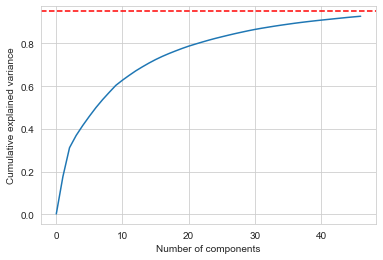

In [61]:
evr_plot(pipeline)

___
### 3 Algorithm Evaluation



A type of algorithm known as Recommender System is required to solve the problem in hand - provide an automated service that recommends new business leads to a user given his current clients portfolio. There's many different approaches to create a Recommender System, which depend on the original data format and size.  
The main approaches are:  

* [Simple Recommenders / Popularity Based System](https://www.datacamp.com/community/tutorials/recommender-systems-python): In popularity based recommender systems, the "knowledge of the masses" is used to make recommendations based on, you guessed, what most people like. There is a nice example in the link.

* [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering): In collaborative filtering, the interests of many users (hence collaborative) are used to filter the data and predict the tastes of a certain user. The main idea is that a user gets better recommendations from people that have similar preferences. Usually, it is required that the data presents a user database, and item database, and a way to infer user preferences regarding the items, which may be explicit, like ratings given by each user to the respective item, or it may be some sort of implicit rating as well, like clicks on a type of add. Commonly, the system may be constructed by looking for users that rate items simmilarly, or look for simmilarities between items.  

* [Content Based Fitering](http://recommender-systems.org/content-based-filtering/): In content based filtering, the idea is to compare items based on their features/contents, and then recommend similar items to the ones on a user profile. There are several learning techniques to learn a user profile. The linked article quotes that "among the best performers in terms of speed are the Bayesian classifier and relevance feedback".  

* [Hybrid Methods](https://en.wikipedia.org/wiki/Recommender_system#Hybrid_recommender_systems): As the name says, this approach combines different techinques, as in content based filtering, collaborative filtering, etc., to create recommendations based not only on user ratings, but also in items features and characteristics.

**For this project, a Content Based Filtering Recommender System is going to be used**. It can be argued that it's a matter of adapting the dataset so that we obtain the required format required by each approach. That said, to the problem and dataset at hand, a Content Based Filtering Recommender System seems to be the choice that makes more sense since:

* Three portfolios are presented - our user base is of three, and usually to use collaborative filtering many users would be needed (creating simulated profiles could be an idea here).

* These portfolios do not present user ratings (not explicitly, at least) on each of the "items", which are the clients.

* As seen in the previous exploratory data analysis section, each client presents several features that may be used to identify similar observations/clients.  

Also, the scope of the problem does not include the addition of new observations (new clients) to the companies' profiles.  

In [ ]:
market_df_copy.mean()